# Try This Exercise

In [1]:
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import linmix

In this exercise, you again get to work on my data.  

The file `oiii_linmix_test.dat` contains the following columns:
1.  The "eigenvector 1" parameter.  Call that $x1$.
2. The error on eigenvector 1.
3. The log of the radius of the outflow.  Call that $x2$.
4. The error on the log of the radius.
5. The detection flag for log of the radius.  A `0` means that the value is a lower limit.
6. $\log [OIII]_{obs}-\log[OIII]_{pred}$.  Call that $y$.
7. The error on $y$.

## Part 1

- Perform an OLS analysis on $x1$ versus $y$.  Use a Monte Carlo scheme to sample the errors.
- Repeat the analysis using `linmix`.  Plot the data plus errors and the regression bow ties for both OLS and `linmix`.  Discuss.

> Below I have used `OLS` and `linmix` to get regression parameters for X1 versus y. I then sample the errors for each point $10^4$ times to get a distribution of these regression parameters (however slope is only plotted). I did this same thing in part 2.

> For X1 vs. y we find a slope of $-0.355 \pm 0.020$ from `OLS` and $-0.378 \pm 0.091$ from `linmix`. The mean values are on average similar, however there is a much larger spread in slope values from `linmix`.

In [2]:
fn = '../../lectures/lecture15/oiii_linmix_test.dat'
data = np.loadtxt(fn, skiprows=1)
X1 = data[:, 0]
eX1 = data[:, 1]
X2 = data[:, 2]
eX2 = data[:, 3]
detection = data[:, 4]
y = data[:, 5]
ey = data[:, 6]

In [3]:
# use OLS
ols = OLS(y, add_constant(X1)).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     20.61
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           9.75e-05
Time:                        07:47:42   Log-Likelihood:                -24.245
No. Observations:                  30   AIC:                             52.49
Df Residuals:                      28   BIC:                             55.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0042      0.103     -9.787      0.0

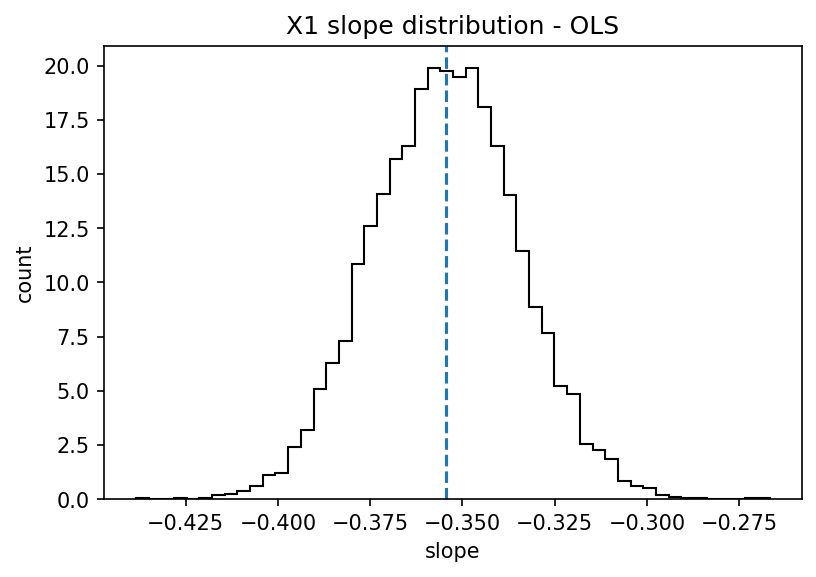

In [4]:
# sample the errors
n_iter = 10000
n = len(X1)

scatterX1 = np.empty((n_iter, n))
scattery = np.empty((n_iter, n))

for i in range(n):
    scatterX1[:, i] = np.random.normal(0., eX1[i], n_iter)
    scattery[:, i] = np.random.normal(0., ey[i], n_iter)

def sample_ols_params(X, y, scatterX, scattery):
    X_s = X + scatterX
    y_s = y + scattery
    
    ols_s = OLS(y_s, add_constant(X_s)).fit()
    return np.array(ols_s.params)

params = np.empty((n_iter, 2))
for i in range(n_iter):
    params[i] = sample_ols_params(X1, y, scatterX1[i], scattery[i])

slope_ols = params[:, 1]
    
mean_ols = slope_ols.mean()
std_ols = slope_ols.std()
    
fig, ax = plt.subplots(dpi=150)

ax.hist(slope_ols, 50, histtype='step', density=True, color='k')
ax.axvline(mean_ols, color='tab:blue', ls='--')

ax.set_xlabel('slope')
ax.set_ylabel('count')
ax.set_title('X1 slope distribution - OLS')

plt.show()

ols: -0.355 +/- 0.020
linmix: -0.378 +/- 0.091


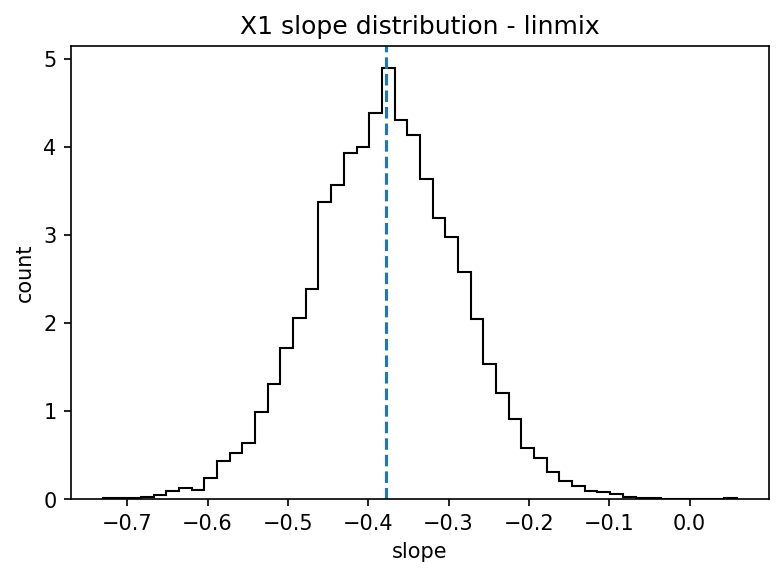

In [5]:
# use linmix
lin = linmix.LinMix(X1, y, eX1, ey, K=5, seed=2)
lin.run_mcmc(silent=True)

intercept_lin = lin.chain['alpha'].astype(np.float)
slope_lin = lin.chain['beta'].astype(np.float)

mean_lin = slope_lin.mean()
std_lin = slope_lin.std()

print(f'ols: {mean_ols:.3f} +/- {std_ols:.3f}')
print(f'linmix: {mean_lin:.3f} +/- {std_lin:.3f}')

fig, ax = plt.subplots(dpi=150)

ax.hist(slope_lin, 50, histtype='step', density=True, color='k')
ax.axvline(mean_lin, color='tab:blue', ls='--')

ax.set_xlabel('slope')
ax.set_ylabel('count')
ax.set_title('X1 slope distribution - linmix')

plt.show()

In [6]:
n_points = 500
xplot = np.linspace(X1.min(), X1.max(), n_points)

pct_regs = [0.0027, 0.0455, 0.3173, 0.5, 0.6827, 0.9545, 0.9973]
n_samples = len(lin.chain)
f2 = np.arange(n_samples) / n_samples

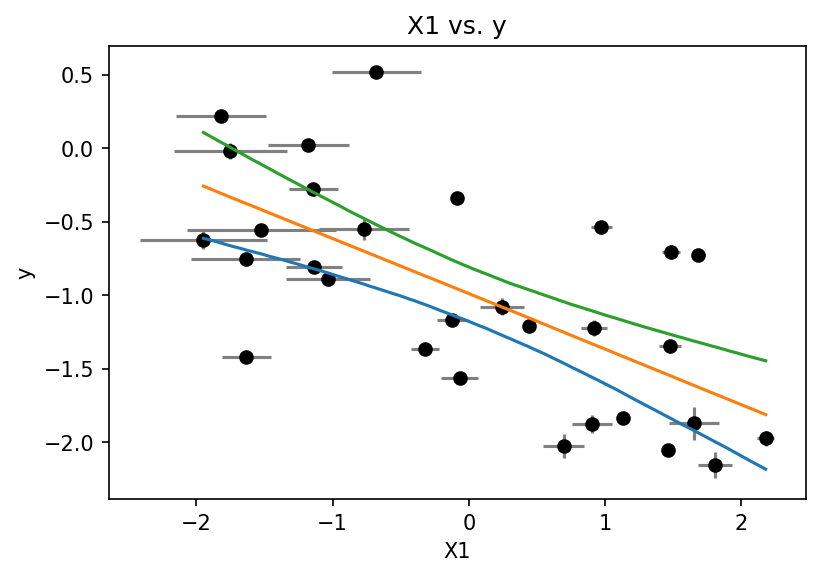

In [7]:
conf = np.empty((n_points, len(pct_regs)))

for i in range(n_points):
    x2 = np.sort(intercept_lin + xplot[i] * slope_lin)
    conf[i] = np.interp(pct_regs, f2, x2)

fig, ax = plt.subplots(dpi=150)

ax.plot(X1, y, 'ko')
ax.errorbar(X1, y, yerr=ey, xerr=eX1,
            marker='o', c='grey', fmt='none', zorder=-1)
ax.plot(xplot, conf[:, 1])
ax.plot(xplot, conf[:, 3])
ax.plot(xplot, conf[:, 5])

ax.set_xlabel('X1')
ax.set_ylabel('y')
ax.set_title('X1 vs. y')

plt.show()

## Part 2

- Repeat the analysis above using $x2$ as the independent variable.  Make suitable plots and discuss.
- Then, repeat with the reduced data set that uses only the detections.  Discuss.

> For X2 vs. y we find a slope of $-0.214 \pm 0.015$ from `OLS` and $-0.226 \pm 0.115$ from `linmix`. Again we find similar slope values from each, however the spread on the slope is much larger from `linmix`.

> Below is also the same analysis but using X2 and y with the detection flag (it was not very clear from the instructions if 0 or 1 was detection, but I assumed `True` = detection). We find from `OLS` a slope of $-0.410 \pm 0.012$ and $-0.412 \pm 0.132$ from `linmix`. These values are vastly different from those of the complete X2 and y data. Looking at the X2 vs. y plots, this is likely just an artifact of a small sample size, such that points have a much higher weight, so taking them out results in a much different result.

In [8]:
# use OLS
ols = OLS(y, add_constant(X2)).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.075
Date:                Sun, 08 Nov 2020   Prob (F-statistic):             0.0532
Time:                        07:47:52   Log-Likelihood:                -30.482
No. Observations:                  30   AIC:                             64.96
Df Residuals:                      28   BIC:                             67.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5833      0.245     -2.382      0.0

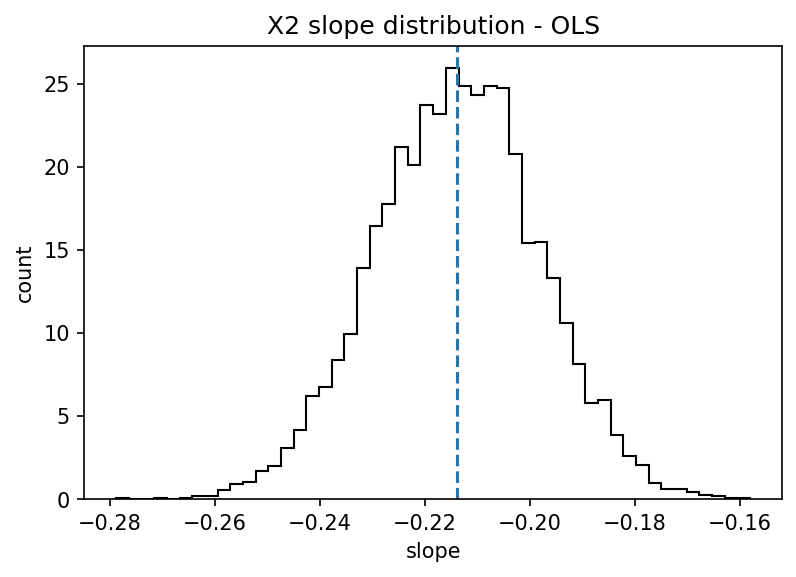

In [9]:
# sample the errors
n = len(X2)

scatterX2 = np.empty((n_iter, n))
scattery = np.empty((n_iter, n))

for i in range(n):
    scatterX2[:, i] = np.random.normal(0., eX2[i], n_iter)
    scattery[:, i] = np.random.normal(0., ey[i], n_iter)

params = np.empty((n_iter, 2))
for i in range(n_iter):
    params[i] = sample_ols_params(X2, y, scatterX2[i], scattery[i])

slope_ols = params[:, 1]
    
mean_ols = slope_ols.mean()
std_ols = slope_ols.std()
    
fig, ax = plt.subplots(dpi=150)

ax.hist(slope_ols, 50, histtype='step', density=True, color='k')
ax.axvline(mean_ols, color='tab:blue', ls='--')

ax.set_xlabel('slope')
ax.set_ylabel('count')
ax.set_title('X2 slope distribution - OLS')

plt.show()

ols: -0.214 +/- 0.016
linmix: -0.226 +/- 0.115


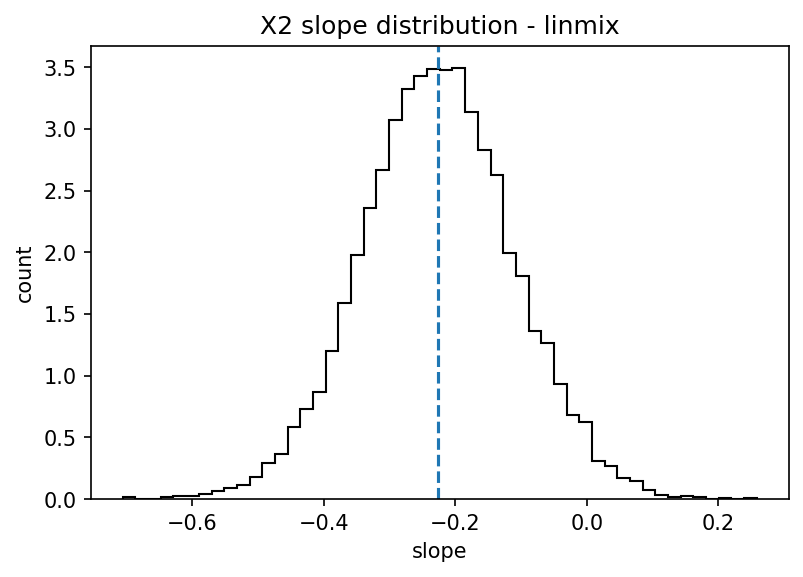

In [10]:
# use linmix
lin = linmix.LinMix(X2, y, eX2, ey, K=5, seed=2)
lin.run_mcmc(silent=True)

intercept_lin = lin.chain['alpha'].astype(np.float)
slope_lin = lin.chain['beta'].astype(np.float)

mean_lin = slope_lin.mean()
std_lin = slope_lin.std()

print(f'ols: {mean_ols:.3f} +/- {std_ols:.3f}')
print(f'linmix: {mean_lin:.3f} +/- {std_lin:.3f}')

fig, ax = plt.subplots(dpi=150)

ax.hist(slope_lin, 50, histtype='step', density=True, color='k')
ax.axvline(mean_lin, color='tab:blue', ls='--')

ax.set_xlabel('slope')
ax.set_ylabel('count')
ax.set_title('X2 slope distribution - linmix')

plt.show()

In [11]:
xplot = np.linspace(X2.min(), X2.max(), n_points)

n_samples = len(lin.chain)
f2 = np.arange(n_samples) / n_samples

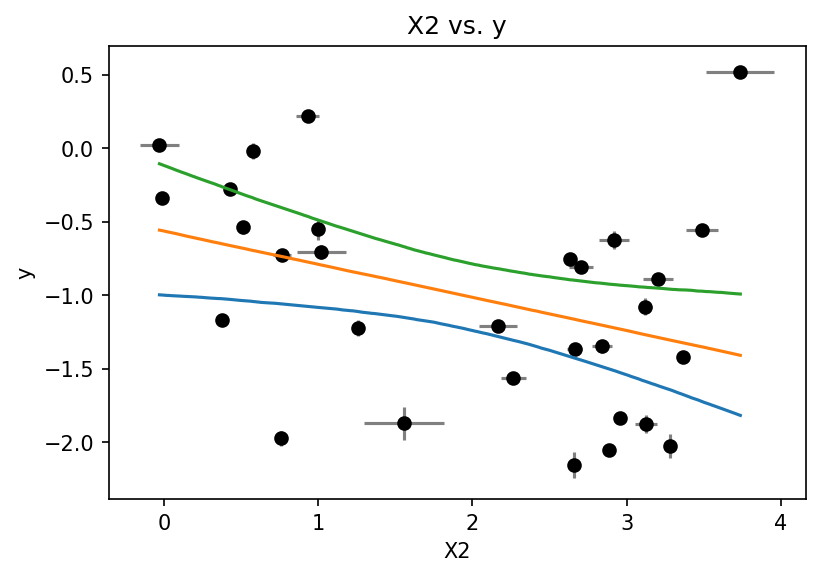

In [12]:
conf = np.empty((n_points, len(pct_regs)))

for i in range(n_points):
    x2 = np.sort(intercept_lin + xplot[i] * slope_lin)
    conf[i] = np.interp(pct_regs, f2, x2)

fig, ax = plt.subplots(dpi=150)

ax.plot(X2, y, 'ko')
ax.errorbar(X2, y, yerr=ey, xerr=eX2,
            marker='o', c='grey', fmt='none', zorder=-1)
ax.plot(xplot, conf[:, 1])
ax.plot(xplot, conf[:, 3])
ax.plot(xplot, conf[:, 5])

ax.set_xlabel('X2')
ax.set_ylabel('y')
ax.set_title('X2 vs. y')

plt.show()

In [13]:
mask = detection == 1.

det_X2 = X2[mask]
det_eX2 = eX2[mask]
det_y = y[mask]
det_ey = ey[mask]

In [14]:
# use OLS
ols = OLS(det_y, add_constant(det_X2)).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     12.37
Date:                Sun, 08 Nov 2020   Prob (F-statistic):            0.00246
Time:                        07:48:03   Log-Likelihood:                -15.523
No. Observations:                  20   AIC:                             35.05
Df Residuals:                      18   BIC:                             37.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3845      0.207     -1.859      0.0

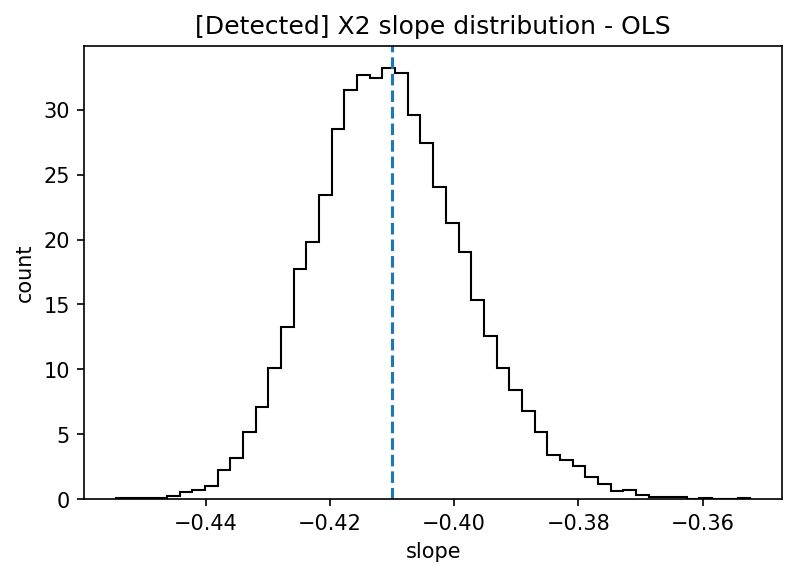

In [15]:
# sample the errors
n = len(det_X2)

scatterX2 = np.empty((n_iter, n))
scattery = np.empty((n_iter, n))

for i in range(n):
    scatterX2[:, i] = np.random.normal(0., det_eX2[i], n_iter)
    scattery[:, i] = np.random.normal(0., det_ey[i], n_iter)

params = np.empty((n_iter, 2))
for i in range(n_iter):
    params[i] = sample_ols_params(det_X2, det_y, scatterX2[i], scattery[i])

slope_ols = params[:, 1]
    
mean_ols = slope_ols.mean()
std_ols = slope_ols.std()
    
fig, ax = plt.subplots(dpi=150)

ax.hist(slope_ols, 50, histtype='step', density=True, color='k')
ax.axvline(mean_ols, color='tab:blue', ls='--')

ax.set_xlabel('slope')
ax.set_ylabel('count')
ax.set_title('[Detected] X2 slope distribution - OLS')

plt.show()

ols: -0.410 +/- 0.012
linmix: -0.412 +/- 0.132


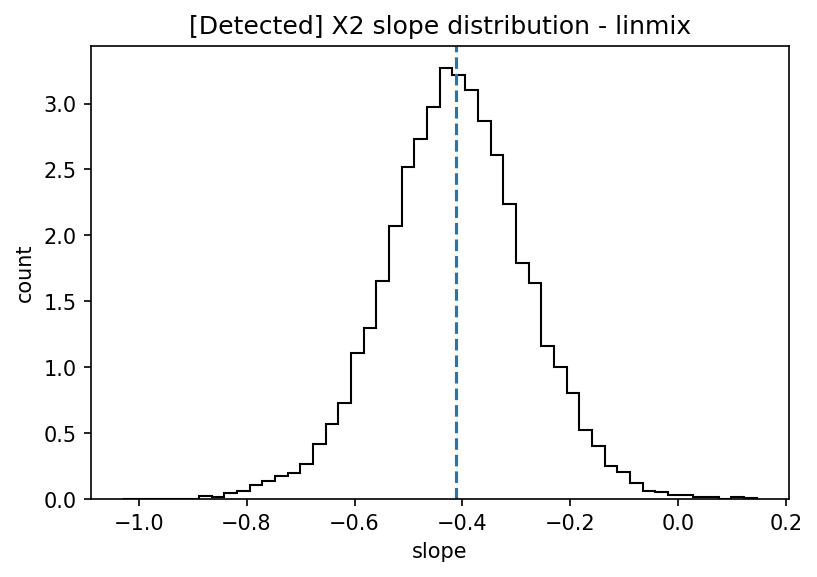

In [16]:
# use linmix
lin = linmix.LinMix(det_X2, det_y, det_eX2, det_ey, K=5, seed=2)
lin.run_mcmc(silent=True)

intercept_lin = lin.chain['alpha'].astype(np.float)
slope_lin = lin.chain['beta'].astype(np.float)

mean_lin = slope_lin.mean()
std_lin = slope_lin.std()

print(f'ols: {mean_ols:.3f} +/- {std_ols:.3f}')
print(f'linmix: {mean_lin:.3f} +/- {std_lin:.3f}')

fig, ax = plt.subplots(dpi=150)

ax.hist(slope_lin, 50, histtype='step', density=True, color='k')
ax.axvline(mean_lin, color='tab:blue', ls='--')

ax.set_xlabel('slope')
ax.set_ylabel('count')
ax.set_title('[Detected] X2 slope distribution - linmix')

plt.show()

In [17]:
xplot = np.linspace(det_X2.min(), det_X2.max(), n_points)

n_samples = len(lin.chain)
f2 = np.arange(n_samples) / n_samples

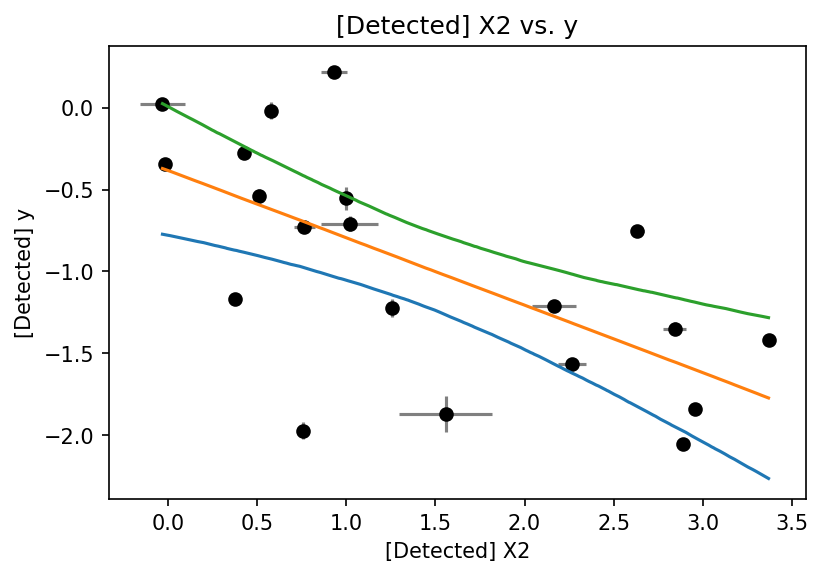

In [18]:
conf = np.empty((n_points, len(pct_regs)))

for i in range(n_points):
    x2 = np.sort(intercept_lin + xplot[i] * slope_lin)
    conf[i] = np.interp(pct_regs, f2, x2)

fig, ax = plt.subplots(dpi=150)

ax.plot(det_X2, det_y, 'ko')
ax.errorbar(det_X2, det_y, yerr=det_ey, xerr=det_eX2,
            marker='o', c='grey', fmt='none', zorder=-1)
ax.plot(xplot, conf[:, 1])
ax.plot(xplot, conf[:, 3])
ax.plot(xplot, conf[:, 5])

ax.set_xlabel('[Detected] X2')
ax.set_ylabel('[Detected] y')
ax.set_title('[Detected] X2 vs. y')

plt.show()